In [23]:
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout, LSTM, Bidirectional, GRU, Input, Conv1D, concatenate
from keras.models import Model
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import json
import pickle
np.random.seed(1234)


### Load observation light curves

In [2]:
from ast import literal_eval

columns = ['id', 'morphology', 'passband', 'params', 'data', 'origin', 'period', 'target', 'epoch', 'meta']
df = pd.read_csv("/Users/vierka/Desktop/observed_lc.csv", sep="|", header=None)
df.columns = columns
dff = df[["target", "morphology", "data"]]

processed_data = [literal_eval(_data)["flux"] for _data in df["data"]]
morphology = df[["morphology"]].values

processed_data = np.array(processed_data, dtype=np.float32)


In [3]:
target = []
for i in morphology:
    if i == 'over-contact':
        target.extend([0])
    if i == 'semi-detached':
        target.extend([1])
    if i == 'detached':
        target.extend([1])
target = np.array(target)
target = np_utils.to_categorical(target, 2)


In [4]:
target = []
oc, sd, dt = 0, 0, 0
for row in morphology:
    if row == 'over-contact':
        target.append(0)
        oc += 1
    elif row == 'detached' :
        target.append(1)
        dt += 1
        
target = np.array(target)
print("Over-contact: " + str(oc) + "\n" + "Semi-detached: " + str(sd) + "\n" + "Detached: " + str(dt))

Over-contact: 47
Semi-detached: 0
Detached: 53


47
53


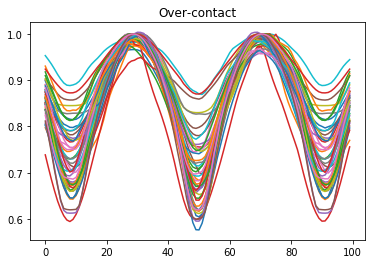

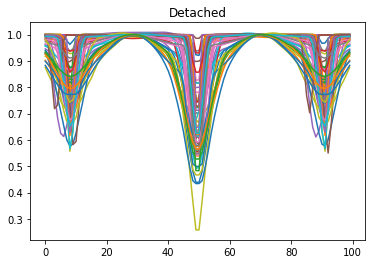

In [5]:
OCcurves, DTcurves = [], []
for i in range(len(target)):
    if target[i] == 0:
        OCcurves.append(processed_data[i])
    elif target[i] == 1:
        DTcurves.append(processed_data[i])
        
print(len(OCcurves))
print(len(DTcurves))

for i in range(len(OCcurves)):
    plt.plot(OCcurves[i])
plt.title('Over-contact')
plt.savefig('over.png')
plt.show()


for i in range(len(DTcurves)):
    plt.plot(DTcurves[i])
plt.title('Detached')
plt.savefig('detached.png')
plt.show()



### Load synthetic data generated from ELISa software

In [6]:
data = pd.read_csv('/Users/vierka/Desktop/DATA COKINA/df_all.csv_v2')
data.head()

,Unnamed: 0,id,morphology,params,phases,generic_bessell_b,generic_bessell_v,generic_bessell_r,primary_t_eff,secondary_t_eff,primary_surface_potential,secondary_surface_potential,primary_mass,secondary_mass,period,inclination,spotty
0,0,1,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.2...","[-0.6, -0.5878787878787879, -0.575757575757575...","[4.081591544439083e+23, 4.031652090826959e+23,...","[9.873049593587627e+23, 9.760395127000434e+23,...","[1.3747087279830434e+24, 1.3597310499829646e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.2,35.0,1
1,1,2,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.3...","[-0.6, -0.5878787878787879, -0.575757575757575...","[6.858420674472336e+23, 6.77839214297677e+23, ...","[1.6727093360156839e+24, 1.6546225148187935e+2...","[2.3229246430355212e+24, 2.2990574599057018e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.3,35.0,1
2,2,3,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.2...","[-0.6, -0.5878787878787879, -0.575757575757575...","[4.154670345913387e+23, 4.1078852654519154e+23...","[1.0057136315963416e+24, 9.95135723875756e+23,...","[1.3991268037182663e+24, 1.3849947154567012e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.2,35.0,0
3,3,4,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.3...","[-0.6, -0.5878787878787879, -0.575757575757575...","[6.87545071052127e+23, 6.795238703023904e+23, ...","[1.6766406596411532e+24, 1.6585336954130392e+2...","[2.3278600928811596e+24, 2.3039841455496383e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.3,35.0,0
4,4,5,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.5...","[-0.6, -0.5878787878787879, -0.575757575757575...","[1.496209461064851e+24, 1.4832596392814377e+24...","[3.6264470413553653e+24, 3.5968159381407736e+2...","[4.938565049205014e+24, 4.898473393857681e+24,...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.5,35.0,1


In [7]:
data=data[data['spotty']==0]
data.shape

(491425, 17)

In [8]:
for row in data['generic_bessell_v']:
    row = json.loads(row)

In [8]:
newData = []
for row in data['generic_bessell_v']:
    row = json.loads(row)
    minValueOfRow, maxValueOfRow = min(row), max(row)
    newRow = []
    for valueIndex in range(len(row)):
        row[valueIndex] = (row[valueIndex] - minValueOfRow) / (maxValueOfRow - minValueOfRow)
        newRow.append([row[valueIndex]])
    newData.append(newRow)
    
newData = np.array(newData)

In [9]:
target = []
oc, dt = 0, 0
for row in data['morphology']:
    if row == 'over-contact':
        target.append(0)
        oc += 1
    elif row == 'detached' :
        target.append(1)
        dt += 1
        
target = np.array(target)
print("Over-contact: " + str(oc) + "\n" + "Detached: " + str(dt))

Over-contact: 45869
Detached: 445556


45869
445556


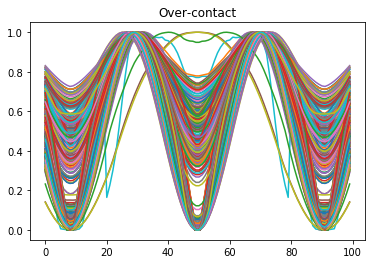

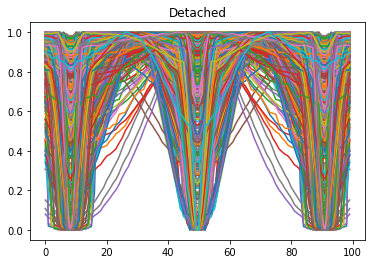

In [10]:
from random import randint

OCcurves, DTcurves = [], []
for i in range(len(target)):
    if target[i] == 0:
        OCcurves.append(newData[i])
    elif target[i] == 1:
        DTcurves.append(newData[i])
        
print(len(OCcurves))
print(len(DTcurves))

for i in range(1000):
    rnd = randint(0, 45868)
    plt.plot(OCcurves[rnd])
plt.title('Over-contact')
plt.show()

for i in range(1000):
    rnd = randint(0, 445555)
    plt.plot(DTcurves[rnd])
plt.title('Detached')
plt.show()

### Modeling

In [24]:
inputs = Input(shape=(100,1))
a = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputs)
a = Flatten()(a)
b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(100,1))(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)
x = concatenate([a,b])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
classifier = Model(inputs=inputs, outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100, 1)       0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 98, 32)       128         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 49, 32)       0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 47, 32)       3104        max_pooling1d_9[0][0]            
____________________________________________________________________________________________

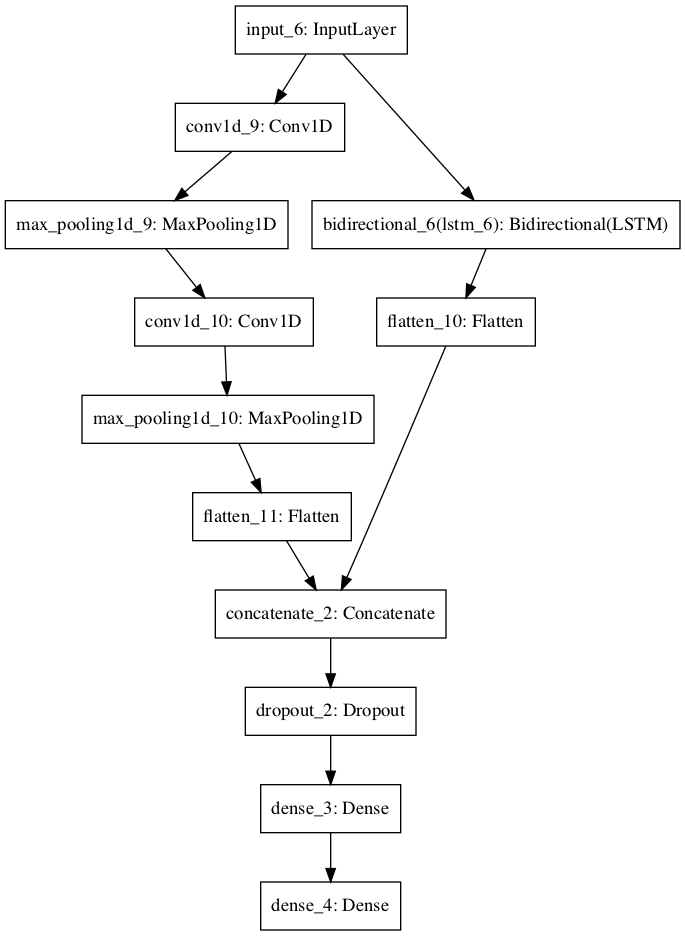

In [25]:
from keras.utils import plot_model
plot_model(classifier, to_file='model.png')

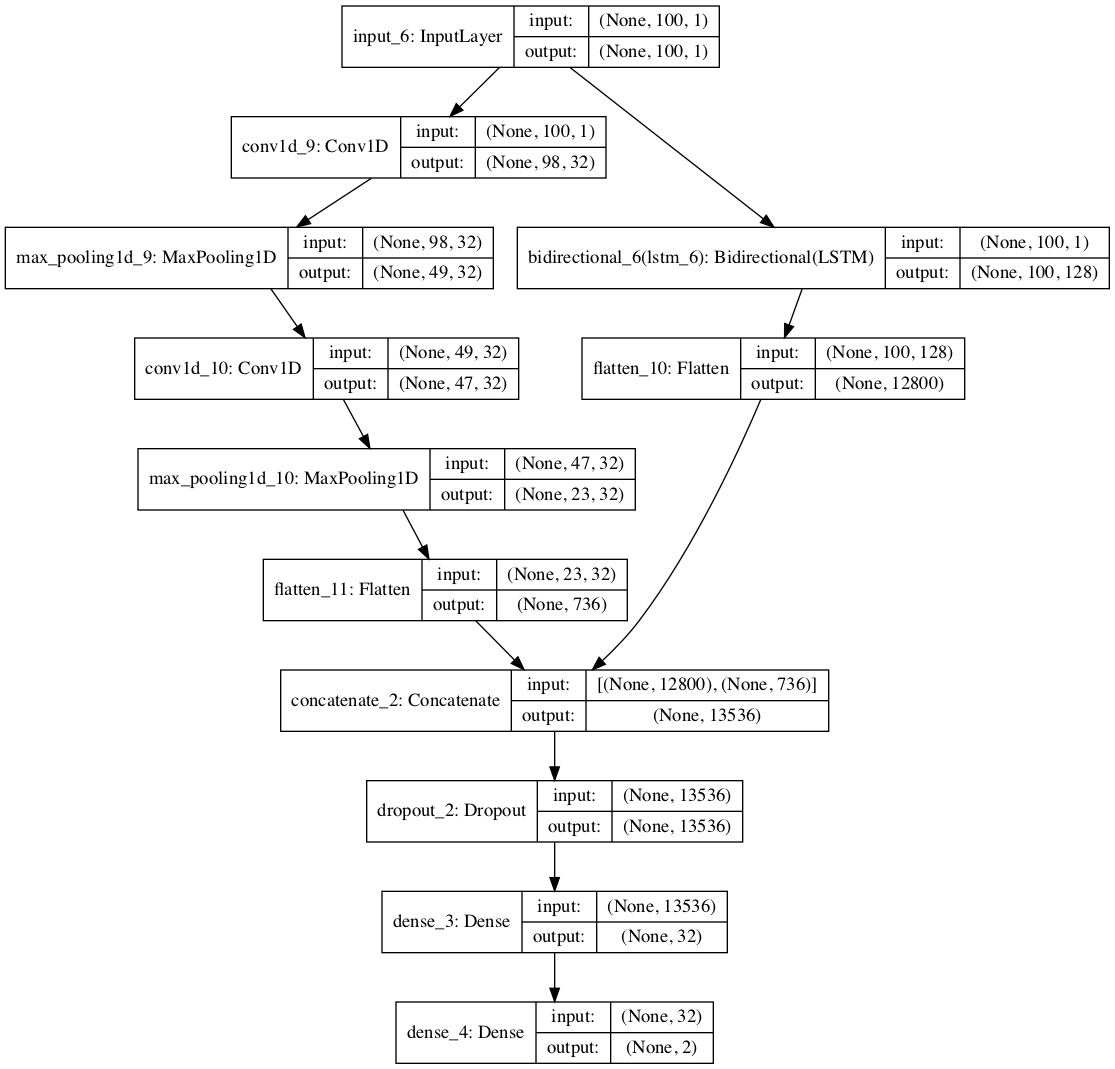

In [26]:
plot_model(classifier, to_file='model1.png', show_shapes=True, show_layer_names=True)

In [27]:
inputs = Input(shape=(100,1))
b = Conv1D(32, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
x = Dense(32, activation='relu')(b)
output = Dense(2, activation='softmax')(x)
classifier = Model(inputs=inputs, outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 98, 32)            128       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 32)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 49, 64)            24832     
_________________________________________________________________
flatten_12 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1003

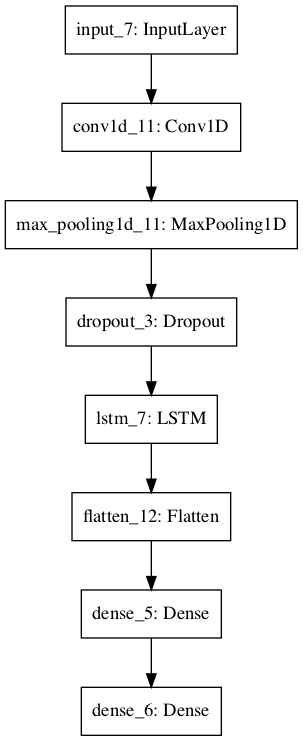

In [28]:
plot_model(classifier, to_file='modelCNN.png')

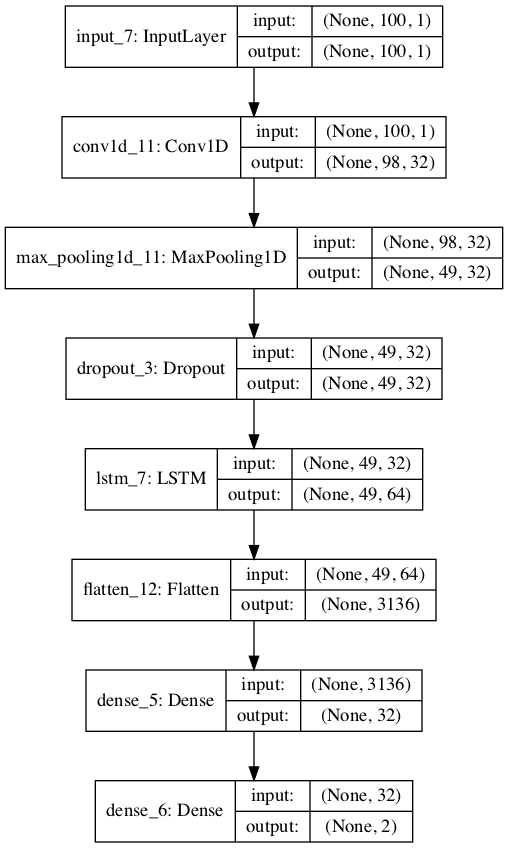

In [29]:
plot_model(classifier, to_file='modelCNN1.png', show_shapes=True, show_layer_names=True)